# **_Advanced Neural Network Model_**

<br>

### __*Import Libraries*__

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import nn

np.random.seed(69)  # set random number generator for reproducibility
warnings.filterwarnings('ignore')

<br>

### __*Dummy (Abstract) Layer*__

In [2]:
class Layer:

    def __init__(self):
        pass

    def forward(self, inp):
        raise NotImplementedError

    def backward(self, inp, grad_outp):
        raise NotImplementedError

<br>

### __*Activation Functions*__

In [3]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inp):
        return np.maximum(0, inp)

    def backward(self, inp, grad_outp):
        return np.where(inp > 0, grad_outp, 0)


class Sigmoid(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inp):
        return 1 / (1 + np.exp(-inp))

    def backward(self, inp, grad_outp):
        sigmoid = self.forward(inp)
        return sigmoid * (1 - sigmoid) * grad_outp


class TanH(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inp):
        return np.tanh(inp)

    def backward(self, inp, grad_outp):
        return grad_outp * (1 - np.power(self.forward(inp), 2))

<br>

### __*Dense Layer*__

In [4]:
class Dense(Layer):
    def __init__(self, inp_units, outp_units, learning_rate=0.01):
        super().__init__()
        self.weights = np.random.random((inp_units, outp_units)) * 2 - 1
        self.biases = np.zeros(outp_units)
        self.learning_rate = learning_rate

    def forward(self, inp):
        return np.matmul(inp, self.weights) + self.biases

    def backward(self, inp, grad_outp):
        self.weights -= self.learning_rate * np.dot(inp.T, grad_outp)
        self.biases -= self.learning_rate * np.sum(grad_outp, axis=0)
        return np.matmul(grad_outp, self.weights.T)

<br>

### __*Multi-Layer Perceptron Model*__

In [5]:
class MLP:
    def __init__(self, learning_rate=0.01):
        self.layers = []
        self.step_lst = []
        self.error_history = []
        self.lr = learning_rate

    def add_layer(self, neuron_count, inp_shape=None, activation='Sigmoid'):
        if inp_shape:
            self.layers.append(Dense(inp_shape, neuron_count, self.lr))
        elif self.layers:
            self.layers.append(Dense(len(self.layers[-2].biases), neuron_count, self.lr))
        else:
            raise ValueError('Must define input shape for input layer.')

        if activation == 'Sigmoid':
            self.layers.append(Sigmoid())
        elif activation == 'ReLU':
            self.layers.append(ReLU())
        elif activation == 'TanH':
            self.layers.append(ReLU())
        else:
            raise ValueError(f'Unknown activation function: {activation}.')

    def forward(self, X):
        activations = []
        for layer in self.layers:
            X = layer.forward(X)
            activations.append(X)
        return activations

    def predict(self, X):
        return np.argmax(self.forward(X)[-1], axis=-1)

    def fit(self, X, y, n_epochs=10, n_errors=1, show_error=True):
        error_sum = 0
        n_errors = n_epochs if n_errors is None else n_errors
        for epoch in range(n_epochs + 1):
            activations = self.forward(np.array(X))
            delta = (activations[-1] - y)
            activations.insert(0, X)
            for i, l in enumerate(self.layers[::-1]):
                delta = l.backward(activations[-i - 2], delta)

            error_sum += np.mean(np.square(y - activations[-1]))

            if epoch % int(n_epochs/n_errors) == 0:
                if show_error:
                    if epoch != 0:
                        print(f'Epoch {epoch}: {error_sum / (n_epochs/n_errors)}')
                    else:
                        print(f'Epoch {epoch}: {error_sum}')

                if epoch != 0:
                    self.error_history.append(error_sum / (n_epochs/n_errors))
                else:
                    self.error_history.append(error_sum)

                self.step_lst.append(epoch)
                error_sum = 0

    def test(self, X, y):
        if len(X) != len(y):
            raise ValueError('You f**king sure about that???')

        match = 0
        predict = self.predict(np.array(X))
        y = np.argmax(y, axis=1)
        for idx in range(len(predict)):
            if predict[idx] == y[idx]:
                match += 1
        return match / len(predict)

    def error_plt(self):
        plt.plot(self.step_lst, self.error_history)
        plt.title('Error over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Mean absolute error')
        plt.show()

<br>

### __*Prepare Heart Dataset*__

In [6]:
# Prepare the dataset
dataset = nn.load_dataset('data/heart.csv')
train_data, test_data = nn.heart_split_dataset(dataset, shuffle=True)
X_train, y_train = nn.xy_split_dataset(train_data)
X_test, y_test = nn.xy_split_dataset(test_data)

input_size = len(X_train[0])
output_size = len(y_train[0])

# Show structure of dataset
heart = pd.read_csv('data/heart.csv')
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<br>

### __*The Heart Neural Network Model Training*__

In [97]:
heart_nn = MLP(0.0001)

heart_nn.add_layer(30, input_size, activation='Sigmoid')
heart_nn.add_layer(30, activation='Sigmoid')
heart_nn.add_layer(output_size, activation='Sigmoid')

heart_nn.fit(X_train, y_train, 10_000, n_errors=None, show_error=False)

print(f'Accuracy of the Network: {heart_nn.test(X_test, y_test)*100}%')

Accuracy of the Network: 93.91304347826087%


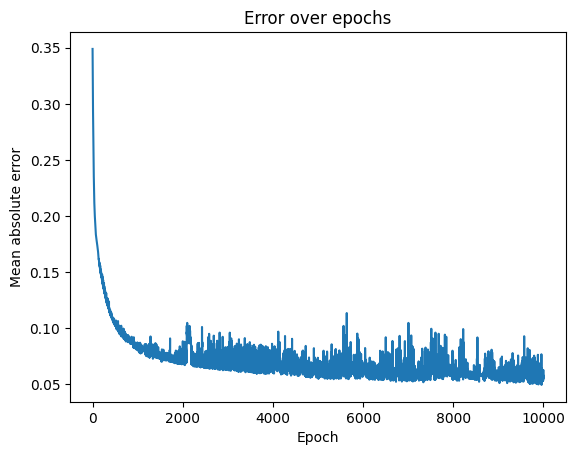

In [98]:
heart_nn.error_plt()

<br>

### __*Prepare Cancer Dataset*__

In [86]:
# Prepare the dataset
dataset = nn.load_dataset('data/cancer.csv')
train_data, test_data = nn.cancer_split_dataset(dataset, shuffle=True)
X_train, y_train = nn.xy_split_dataset(train_data, data='cancer')
X_test, y_test = nn.xy_split_dataset(test_data, data='cancer')

input_size = len(X_train[0])
output_size = len(y_train[0])

# Show structure of dataset
heart = pd.read_csv('data/cancer.csv')
heart.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<br>

### __*The Cancer Neural Network Model Training*__

In [95]:
cancer_nn = MLP(0.0001)

cancer_nn.add_layer(32, input_size, activation='Sigmoid')
cancer_nn.add_layer(16, activation='Sigmoid')
cancer_nn.add_layer(output_size, activation='Sigmoid')

cancer_nn.fit(X_train, y_train, 15_000, n_errors=15, show_error=True)

print(f'Accuracy of the Network: {cancer_nn.test(X_test, y_test)*100}%')

Epoch 0: 0.33565247353089833
Epoch 1000: 0.15117069142427664
Epoch 2000: 0.08922722351835917
Epoch 3000: 0.07434773766587238
Epoch 4000: 0.07033213748105986
Epoch 5000: 0.06852593174881445
Epoch 6000: 0.06482531618461979
Epoch 7000: 0.06387419027039731
Epoch 8000: 0.06670429449679473
Epoch 9000: 0.07179340217425888
Epoch 10000: 0.07293195444972907
Epoch 11000: 0.07073958729746087
Epoch 12000: 0.06738037123673254
Epoch 13000: 0.06596017952316559
Epoch 14000: 0.06566517923249122
Epoch 15000: 0.06558410977030169
Accuracy of the Network: 95.65217391304348%


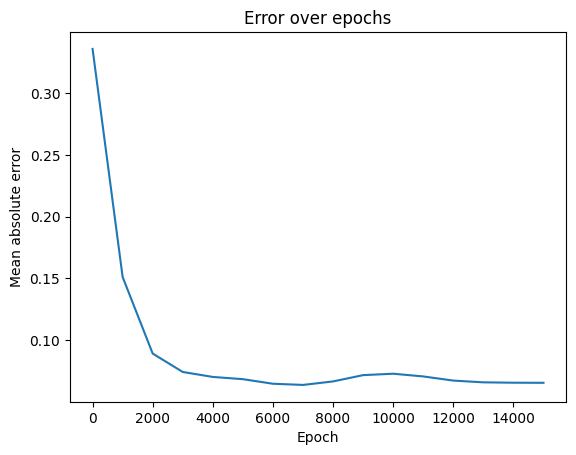

In [96]:
cancer_nn.error_plt()

<br>

### __*The Demo Iris Neural Network Model*__

In [101]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

iris_dataset = load_iris()
X_dataset = StandardScaler().fit_transform(iris_dataset.data)
y_dataset = pd.get_dummies(LabelEncoder().fit_transform(iris_dataset.target)).values

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=0)

iris_nn = MLP(0.01)

iris_nn.add_layer(4, X_dataset.shape[1], activation='TanH')
iris_nn.add_layer(y_dataset.shape[1], activation='Sigmoid')

iris_nn.fit(X_train, y_train, n_epochs=100, n_errors=10)

print(f'Accuracy of the Network: {iris_nn.test(X_test, y_test)*100}%')

Epoch 0: 0.33547350049610714
Epoch 10: 0.19551181124341552
Epoch 20: 0.1315612380646594
Epoch 30: 0.10445575037794945
Epoch 40: 0.08129804127122026
Epoch 50: 0.06545775453346644
Epoch 60: 0.053610430110575626
Epoch 70: 0.04445378128821664
Epoch 80: 0.03756395471088784
Epoch 90: 0.032380646734978154
Epoch 100: 0.028485524226498377
Accuracy of the Network: 100.0%


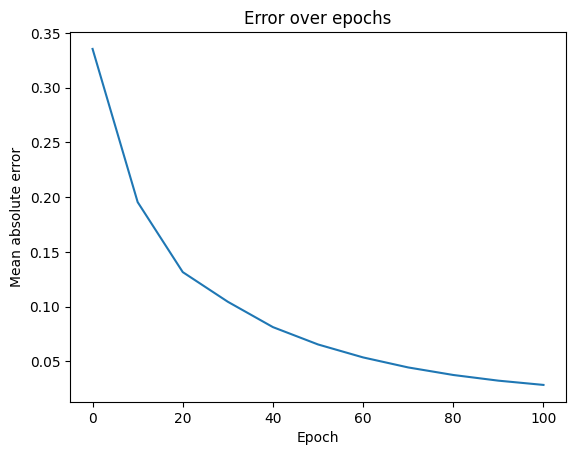

In [102]:
iris_nn.error_plt()